In [1]:
include("/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/foamLia.jl")
using foamLia

baseCase = OpenFoam("/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase");
initCase(baseCase,"/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/juliabase/");
faces,cells = readMesh(baseCase);
points,indices = reshapeMesh(baseCase);

# let's go get the foward four points of each cell
# only get the yz coordinates
cellPoints = zeros(size(baseCase.fullMesh["cellFaces"])[2],4,3)
for cellID in 1:size(baseCase.fullMesh["cellFaces"])[2]
    faces_tmp = baseCase.fullMesh["cellFaces"][:,cellID]
    # println(faces)
    pointList = Int[]
    for faceID in 1:6
        face = faces_tmp[faceID]
        pointIDs = baseCase.fullMesh["faces"][:,face]
        # println(pointIDs)
        for pointID in 1:4
            point = pointIDs[pointID]
            if point ∉ pointList
                push!(pointList,point)
            end
        end
    end
    # println(pointList)
    # print(size(pointList))
    j = 0
    for (i,point) in enumerate(pointList)
        # println(i)
        # println(point)
        # println(baseCase.fullMesh["points"][:,point])
        pointXYZ = baseCase.fullMesh["points"][:,point]
        if pointXYZ[1] > 0
            j += 1
            cellPoints[cellID,j,:] = pointXYZ
        end
    end
end

/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase/system exists
/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase/constant/polyMesh exists
/Users/andyreagan/work/2014/11-foamLab-julia/foamLia/test/testPlotCase/0 exists
copying over base case
writing out controlDict
writing out fvSchemes
writing out fvSolution
writing out setFieldsDict
writing out RASProperties
writing out transportProperties
writing out turbulenceProperties
writing out g
writing out T
writing out phi
writing out U
writing out p


In [2]:
# all of the function that are necessary for plotting
using PyPlot
using PyCall
@pyimport matplotlib as mpl
patches = mpl.pymember("patches")

RdYlBu = readcsv("/Users/andyreagan/work/2014/11-foamLab-julia/RdYlBu.csv");
function cmapper(cmap,val)
    squeeze(cmap[min(max(ceil(val*255),1),255),:],1)
end

lookup_table = zeros(40000,4)
lookup_table[1:19999,:] = repmat([1,2,4,3]',19999,1)
# bottom right
lookup_table[20000:30000,:] = repmat([1,2,3,4]',10001,1)
# flip every 40th
lookup_table[20000:40:29999,:] = repmat([1,2,4,3]',250,1)
lookup_table[30001:40000,:] = repmat([1,2,4,3]',10000,1)
lookup_table[40,:] = [1,2,3,4]'
lookup_table[39961:40000,:] = repmat([1,2,3,4]',40,1)
lookup_table[29961:29999,:] = repmat([1,2,4,3]',39,1)
function cell_point_order(cellID)
    # a lookup for how to reorder the point
    return squeeze(lookup_table[cellID,:],1)
end

function plot_loop_whole(T)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:],closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    # PyPlot.matplotlib[:pyplot][:savefig]("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-mode01.pdf")
end

function plot_loop_whole_save(T,fname)
    # plot the normalized temp T
    # around the whole loop
    fig = PyPlot.matplotlib[:pyplot][:figure](figsize=(10,10))
    ax = fig[:add_axes]([0.2,0.2,0.7,0.7])
    for cellID in 1:40000
        pts = cellPoints[cellID,:,2:3]
        # println(pts)
        p = patches[:Polygon](squeeze(pts,1)[cell_point_order(cellID),:],closed=true,edgecolor="none",facecolor=cmapper(RdYlBu,T[cellID]),rasterized=true)
        ax[:add_patch](p)
    end
    ax[:set_xlim]([-1,1]*0.38)
    ax[:set_ylim]([-1,1]*0.38)
    # optionally save it to PDF:
    PyPlot.matplotlib[:pyplot][:savefig](fname)
end

INFO: Loading help data...


plot_loop_whole_save (generic function with 1 method)

In [5]:
include("/Users/andyreagan/work/2014/11-foamLab-julia/ensembleFunctions.jl")
tighter_times = 100:2:5000
Phi_timeseries = zeros(length(tighter_times))
for i=1:length(tighter_times)
    println(tighter_times[i])
    Phi_timeseries[i] = readFlux(baseCase,tighter_times[i],faces)
end

100
the flux at time 100 is -1.437369495e-10
102
the flux at time 102 is -1.8147527749999998e-10
104
the flux at time 104 is -2.3126651e-10
106
the flux at time 106 is -2.9559586500000003e-10
108
the flux at time 108 is -3.7796250750000006e-10
110
the flux at time 110 is -4.805405225000001e-10
112
the flux at time 112 is -6.134113449999999e-10
114
the flux at time 114 is -7.897217599999999e-10
116
the flux at time 116 is -1.02478545e-9
118
the flux at time 118 is -1.3346466e-9
120
the flux at time 120 is -1.7360592e-9
122
the flux at time 122 is -2.24816745e-9
124
the flux at time 124 is -2.902811e-9
126
the flux at time 126 is -3.7252414499999995e-9
128
the flux at time 128 is -4.72947745e-9
130
the flux at time 130 is -5.9082043e-9
132
the flux at time 132 is -7.2172613749999996e-9
134
the flux at time 134 is -8.5600911e-9
136
the flux at time 136 is -9.78393355e-9
138
the flux at time 138 is -1.06912529e-8
140
the flux at time 140 is -1.1105371e-8
142
the flux at time 142 is -1.0927

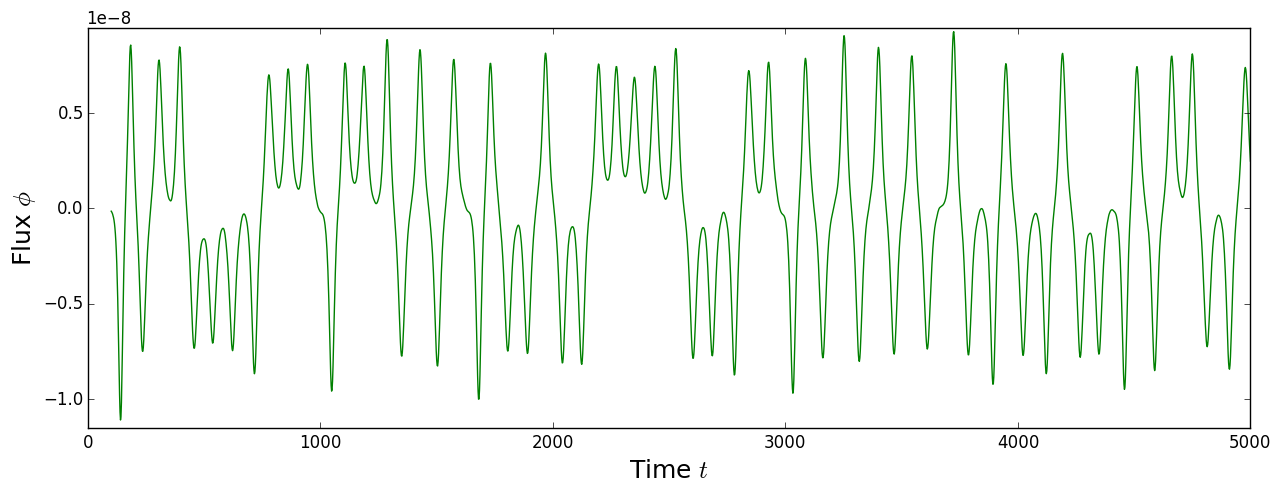

In [6]:
figure(figsize=(15,5))
# plot(times,T_timeseries/maximum(T_timeseries),"b",label="T3-9")
plot(tighter_times,Phi_timeseries,"g",label="flux")
# plot(times,zeros(length(times)),"r")
ylabel("Flux \$\\phi\$",size=18)
xlabel("Time \$t\$",size=18)
# legend(loc="best")
ylim([-1.15e-8,.95e-8])
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD-data-timeseries-longer-wide.png",bbox_inches="tight")
savefig("/Users/andyreagan/work/2014/11-foamLab-julia/figures/DMD/DMD-data-timeseries-longer-wide.pdf",bbox_inches="tight")

In [9]:
# identify all of the times that are pre-reversals, then 2-prior, 3-prior, etc.
# don't have the full timeseries (only evens) so we'll only get reversals at odd times
num_reversals = 0
for i=1:length(tighter_times)-1
    if Phi_timeseries[i] > 0 && Phi_timeseries[i+1] < 0
        println(tighter_times[i])
        num_reversals = num_reversals+1
    elseif Phi_timeseries[i] < 0 && Phi_timeseries[i+1] > 0
        println(tighter_times[i])
        num_reversals = num_reversals+1
    end
end

160
208
268
424
746
990
1076
1316
1388
1464
1536
1626
1704
1766
1926
2004
2158
2562
2808
2974
3056
3122
3206
3282
3358
3432
3504
3574
3660
3752
3918
3982
4156
4228
4482
4550
4622
4780
4942


In [10]:
num_reversals

39

In [14]:
reversal_times = zeros(num_reversals)
reversal = 0
for i=1:length(tighter_times)-1
    if Phi_timeseries[i] > 0 && Phi_timeseries[i+1] < 0
        reversal = reversal+1
        reversal_times[reversal] = tighter_times[i]+1
    elseif Phi_timeseries[i] < 0 && Phi_timeseries[i+1] > 0
        reversal = reversal+1
        reversal_times[reversal] = tighter_times[i]+1
    end
end

println(reversal_times)

[161.0,209.0,269.0,425.0,747.0,991.0,1077.0,1317.0,1389.0,1465.0,1537.0,1627.0,1705.0,1767.0,1927.0,2005.0,2159.0,2563.0,2809.0,2975.0,3057.0,3123.0,3207.0,3283.0,3359.0,3433.0,3505.0,3575.0,3661.0,3753.0,3919.0,3983.0,4157.0,4229.0,4483.0,4551.0,4623.0,4781.0,4943.0]


In [16]:
# look at the dmd modes 1-before reversals


In [18]:
# look at the two before...


In [25]:
diagm(ones(10))

10x10 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [31]:
obs_operator = zeros(20)
obs_operator[1:2:20] = 1
obs_operator = diagm(obs_operator)

20x20 Array{Float64,2}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [32]:
help(linspace)

Base.linspace(start, stop, n)

   Construct a vector of "n" linearly-spaced elements from "start"
   to "stop". See also: "linrange()" that constructs a range
   object.


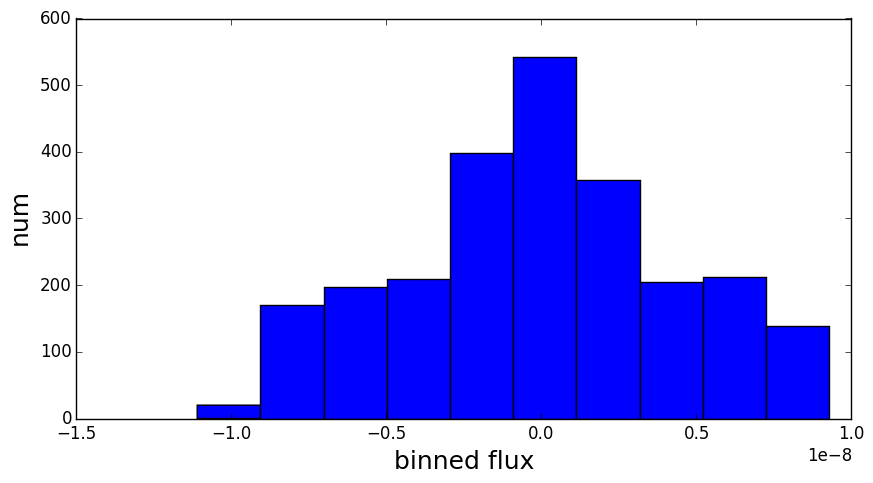

In [43]:
figure(figsize=(10,5))
plt.hist(Phi_timeseries)
ylabel("num",size=18)
xlabel("binned flux",size=18)
# legend(loc="best")
# ylim([-10,10])
savefig("/Users/andyreagan/work/2014/2014-11foamLab-julia/DMD-data-timeseries-longer-hist.png")